In [9]:
%cd ..

d:\4-1d\project


In [35]:
import os
from PIL import Image
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import torch
import numpy as np
from tqdm import tqdm
from torch.nn import functional as F
import matplotlib.pyplot as plt

from models.clip_backbone import OWLViTCLIPBackbone

In [ ]:
#!wget -q https://github.com/google/fonts/raw/main/ofl/sarabun/Sarabun-Regular.ttf

In [38]:
def set_seed(seed: int):
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
set_seed(42)

import matplotlib as mpl
mpl.font_manager.fontManager.addfont('./utils/font/Sarabun-Regular.ttf')
mpl.rc('font', family='Sarabun')

In [2]:
office31_mapping = {
    "back_pack": "กระเป๋าเป้",
    "bike": "จักรยาน",
    "bike_helmet": "หมวกจักรยาน",
    "bookcase": "ตู้หนังสือ",
    "bottle": "ขวดน้ำ",
    "calculator": "เครื่องคิดเลข",
    "desk_chair": "เก้าอี้โต๊ะทำงาน",
    "desk_lamp": "โคมไฟตั้งโต๊ะ",
    "desktop_computer": "คอมพิวเตอร์ตั้งโต๊ะ",
    "file_cabinet": "ตู้เก็บเอกสาร",
    "headphones": "หูฟัง",
    "keyboard": "แป้นพิมพ์",
    "laptop_computer": "แล็ปท็อป",
    "letter_tray": "ถาดใส่จดหมาย",
    "mobile_phone": "โทรศัพท์มือถือ",
    "monitor": "จอภาพ",
    "mouse": "เมาส์",
    "mug": "แก้วน้ำ",
    "paper_notebook": "สมุดบันทึก",
    "pen": "ปากกา",
    "phone": "โทรศัพท์",
    "printer": "เครื่องพิมพ์",
    "projector": "เครื่องฉายภาพ",
    "punchers": "เครื่องเจาะกระดาษ",
    "ring_binder": "แฟ้มสอด",
    "ruler": "ไม้บรรทัด",
    "scissors": "กรรไกร",
    "speaker": "ลำโพง",
    "stapler": "เครื่องเย็บกระดาษ",
    "tape_dispenser": "ที่ตัดเทป",
    "trash_can": "ถังขยะ"
}

In [13]:
# Dataset
class Office31Dataset(Dataset):
    def __init__(self, root_dir: str, mapping: dict, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.mapping = mapping
        self.image_paths = []
        self.captions    = []
        
        for class_name, caption in mapping.items():
            class_dir = os.path.join(root_dir, class_name)
            if os.path.exists(class_dir):
                for img_file in os.listdir(class_dir):
                    if img_file.lower().endswith(('.png', '.jpg', '.jpeg')):
                        self.image_paths.append(os.path.join(class_dir, img_file))
                        self.captions.append(caption)
        
    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert('RGB')
        caption = self.captions[idx]
        
        if self.transform:
            image = self.transform(image)
        
        return image, caption

val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.48145466, 0.4578275, 0.40821073),
                      (0.26862954, 0.26130258, 0.27577711))])

In [28]:
def build_zero_shot_classifier(model, classnames, templates, deveice) :
    model.eval()
    zeroshot_weights = []
    
    with torch.no_grad():
        for classname in tqdm(classnames) :
            texts = [template.format(classname) for template in templates] 
            
            inputs = model.tokenizer(
                texts,
                padding=True,
                truncation=True,
                return_tensors="pt"
            ).to(deveice)
            
            # Encode text
            # ใช้ encode_text ของ OWLViTCLIPBackbone
            text_outputs = model.encode_text(inputs.input_ids, inputs.attention_mask)
            text_features = text_outputs['text_embeds'] # [n_templates, dim]
            
            # Normalize และหาค่าเฉลี่ยของ template
            text_features = F.normalize(text_features, dim=-1)
            class_embedding = text_features.mean(dim=0)
            class_embedding = F.normalize(class_embedding, dim=-1)
            
            zeroshot_weights.append(class_embedding)
    
    # Stack เป็น matrix [dim, num_classes]
    zeroshot_weights = torch.stack(zeroshot_weights, dim=0).T
    return zeroshot_weights

def evaluate_zeroshot(model, data_loader, zeroshot_weights, class_names, device):
    """รัน evaluation"""
    model.eval()
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for images, labels in tqdm(data_loader, desc="Evaluating"):
            images = images.to(device)
            
            # Encode images
            # ใช้ encode_image ของ OWLViTCLIPBackbone
            image_outputs = model.encode_image(images)
            image_features = image_outputs['image_embeds']
            image_features = F.normalize(image_features, dim=-1)
            
            # คำนวณ Similarity (Cosine Similarity)
            # image_features: [batch, dim]
            # zeroshot_weights: [dim, num_classes]
            logits = 100.0 * image_features @ zeroshot_weights
            
            # หา prediction
            preds = torch.argmax(logits, dim=-1)
            
            # แปลง label string เป็น index
            label_indices = [class_names.index(l) for l in labels]
            
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(label_indices)
    
    # คำนวณ Accuracy
    all_preds = np.array(all_preds)
    all_labels = np.array(all_labels)
    accuracy = (all_preds == all_labels).mean()
    
    return accuracy

In [23]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = OWLViTCLIPBackbone()

checkpoint_path = "checkpoints/clip_backbone/s1_freeze/best.pth"
checkpoint = torch.load(checkpoint_path, map_location=device)
model.load_state_dict(checkpoint['model_state_dict'])
model.to(device)
model.eval()

Some weights of CamembertModel were not initialized from the model checkpoint at clicknext/phayathaibert and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


OWLViTCLIPBackbone(
  (vision_model): CLIPVisionModel(
    (vision_model): CLIPVisionTransformer(
      (embeddings): CLIPVisionEmbeddings(
        (patch_embedding): Conv2d(3, 768, kernel_size=(32, 32), stride=(32, 32), bias=False)
        (position_embedding): Embedding(50, 768)
      )
      (pre_layrnorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (encoder): CLIPEncoder(
        (layers): ModuleList(
          (0-11): 12 x CLIPEncoderLayer(
            (self_attn): CLIPAttention(
              (k_proj): Linear(in_features=768, out_features=768, bias=True)
              (v_proj): Linear(in_features=768, out_features=768, bias=True)
              (q_proj): Linear(in_features=768, out_features=768, bias=True)
              (out_proj): Linear(in_features=768, out_features=768, bias=True)
            )
            (layer_norm1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
            (mlp): CLIPMLP(
              (activation_fn): QuickGELUActivation()
       

In [30]:
office31_dataset = Office31Dataset(root_dir="./mydatasets/Office-31/webcam", mapping=office31_mapping, transform=val_transform)
office31_loader = DataLoader(office31_dataset, batch_size=32, shuffle=False, num_workers=0)
print(f"Number of evaluation samples: {len(office31_dataset)}")

Number of evaluation samples: 795


In [31]:
thai_templates = [
    "รูปภาพของ {}",
    "นี่คือรูปภาพของ {}",
    "ภาพนี้แสดงถึง {}",
]

zeroshot_weights = build_zero_shot_classifier(model, list(office31_mapping.values()), thai_templates, device)
accuracy = evaluate_zeroshot(model, office31_loader, zeroshot_weights, list(office31_mapping.values()), device)
print(f"Zero-shot Evaluation Accuracy on Office-31 (webcam): {accuracy * 100:.2f}%")

Evaluating: 100%|██████████| 25/25 [01:29<00:00,  3.59s/it]

Zero-shot Evaluation Accuracy on Office-31 (webcam): 2.26%


In [36]:
class_names = list(office31_mapping.values())
# Visualize per-class accuracy
def analyze_per_class_accuracy(model, data_loader, zeroshot_weights, class_names, device):
    model.eval()
    class_correct = {name: 0 for name in class_names}
    class_total = {name: 0 for name in class_names}
    
    with torch.no_grad():
        for images, labels in tqdm(data_loader, desc="Analyzing per-class accuracy"):
            images = images.to(device)
            
            # Get image features and predictions
            image_outputs = model.encode_image(images)
            image_features = image_outputs['image_embeds']
            
            image_features = F.normalize(image_features, dim=-1)
            logits = 100 * image_features @ zeroshot_weights
            preds = torch.argmax(logits, dim=-1)
            
            # Update per-class metrics
            for i in range(len(labels)):
                label = labels[i]
                pred = preds[i].item()
                class_total[label] += 1
                if pred == class_names.index(label):
                    class_correct[label] += 1
    
    # Calculate and plot per-class accuracy
    accuracies = {name: class_correct[name]/class_total[name] for name in class_names}
    
    plt.figure(figsize=(15, 6))
    plt.bar(accuracies.keys(), accuracies.values())
    plt.xticks(rotation=45, ha='right')
    plt.ylabel('Accuracy')
    plt.title('Per-class Zero-shot Classification Accuracy')
    plt.tight_layout()
    plt.show()
    
    return accuracies


Analyzing per-class performance...


Analyzing per-class accuracy: 100%|██████████| 25/25 [00:51<00:00,  2.05s/it]


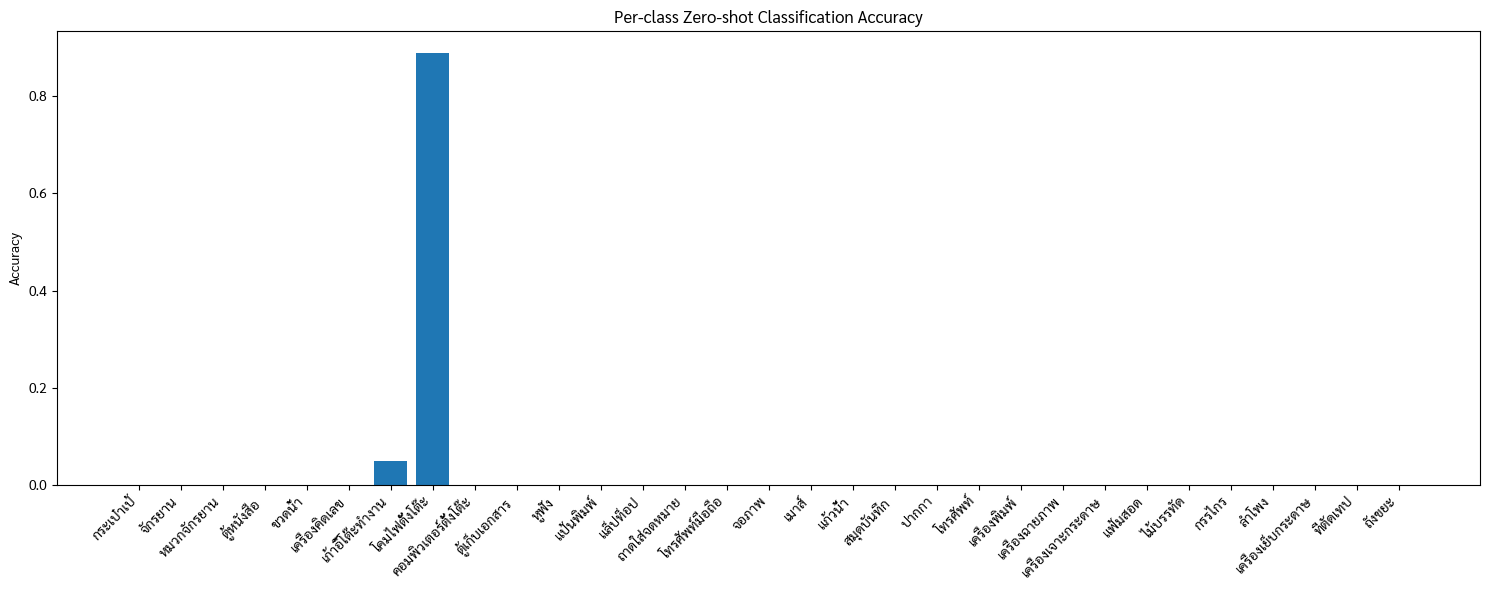

In [39]:
print("\nAnalyzing per-class performance...")
class_accuracies = analyze_per_class_accuracy(model, office31_loader, zeroshot_weights, class_names, device)